# Image Segmentation using Tensorflow

![](https://miro.medium.com/max/2592/1*rZ1vDrOBWqISFiNL5OMEbg.jpeg)

# First question arise what is Image Segmentation?

## So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

![](https://www.tensorflow.org/tutorials/images/segmentation_files/output_a6u_Rblkteqb_0.png)

## We are Using Oxford IIIT Pet Dataset The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories 

*    Class 1 : Pixel belonging to the pet.
*     Class 2 : Pixel bordering the pet.
*     Class 3 : None of the above/ Surrounding pixel.

## Let's Begin

In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
!pip install tensorflow_datasets

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

KeyboardInterrupt: ignored

## The following code performs a simple augmentation of flipping an image. In addition, image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [5]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

## The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH 

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

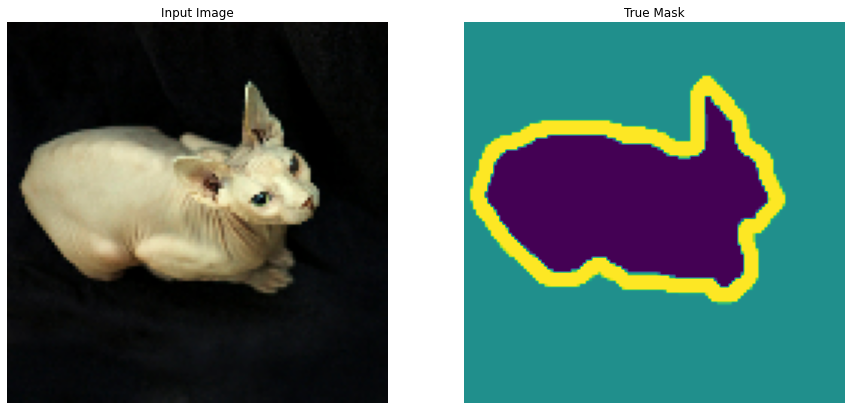

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Now it's time to the define the model

## The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model,

In [ ]:
OUTPUT_CHANNELS = 3

## The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


## The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [8]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Defining the Unet

In [9]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

## Let's Train the model

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Have a quick look at the resulting model architecture

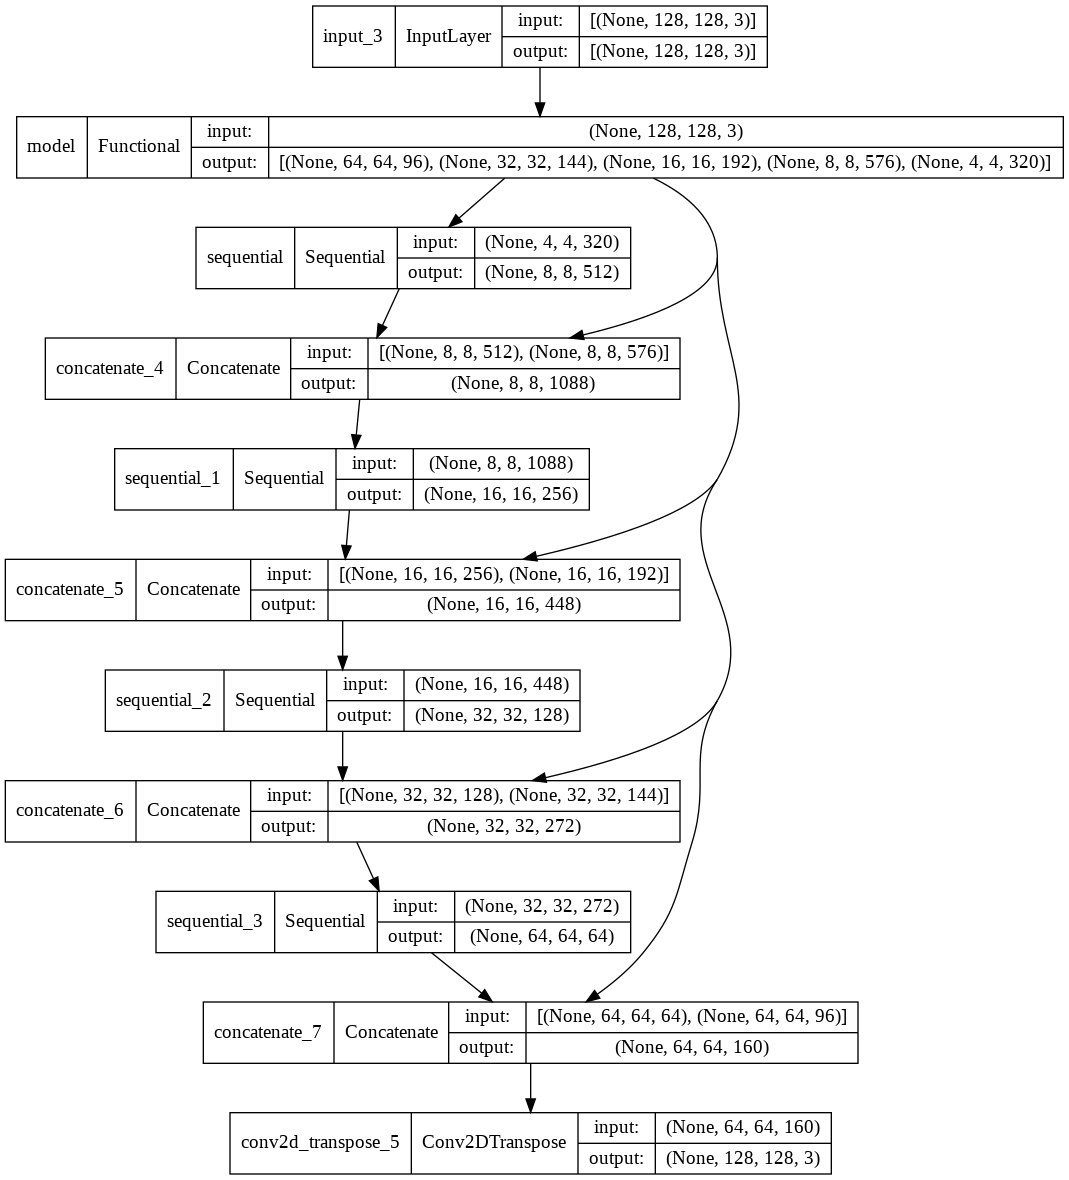

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Let's try out the model to see what it predicts before training.

In [10]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [11]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

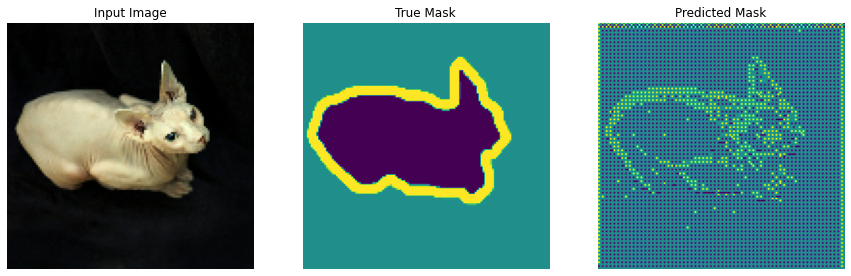

In [ ]:
show_predictions()

## Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

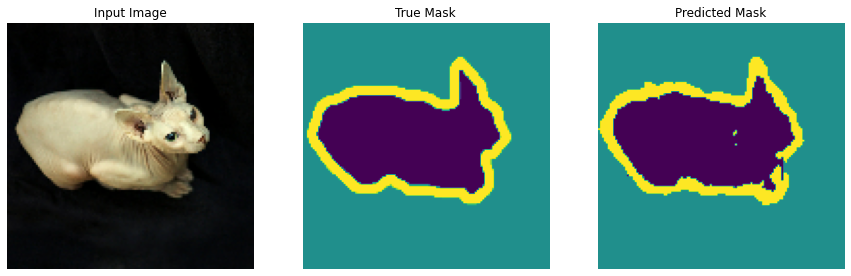


Sample Prediction after epoch 1

3680/3680 [==============================] - 467s 125ms/step - loss: 0.1189 - accuracy: 0.9447 - val_loss: 0.6273 - val_accuracy: 0.8829
Epoch 2/20
2406/3680 [==================>...........] - ETA: 2:36 - loss: 0.0405 - accuracy: 0.9734

KeyboardInterrupt: ignored

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (10, 8)) 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_dataset, 7)

# Using FDL Dataset

In [23]:
!pip install -q git+https://github.com/tensorflow/examples.git

import tensorflow as tf
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

from google.colab import drive
import os
import numpy as np
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array # ImageDataGenerator

In [49]:
# drive.mount('/content/drive/')
# !unzip "drive/MyDrive/fdl21-fdl-dsba.zip" -d "/content" > /dev/null
# os.listdir()

Mounted at /content/drive/


['.config',
 'train_images',
 'train_masks',
 'drive',
 'test_images',
 'train.npy',
 'prepare_submission.py',
 'sample_data']

In [ ]:
# os.chdir("content")
# os.listdir()

['.config', 'model.png', 'drive', 'sample_data']

In [10]:
# SEED = 100
# BATCH_SIZE = 16
# INPUT_SIZE = (128, 128)  # put here the actual resolution

# data_gen_args = dict(featurewise_center=False,
#                      featurewise_std_normalization=False,
#                      rotation_range=90,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.2,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      rescale=None,
#                      preprocessing_function=img_to_array)

# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# # image_datagen.fit(images, augment=True, seed=SEED)  # necessary only if we do centering and normalization
# # mask_datagen.fit(masks, augment=True, seed=SEED)  # necessary only if we do centering and normalization

# image_generator = image_datagen.flow_from_directory(
#     'train_images',
#     class_mode=None,
#     batch_size = BATCH_SIZE, 
#     # target_size = INPUT_SIZE,
#     color_mode="rgb",
#     seed=SEED)

# mask_generator = mask_datagen.flow_from_directory(
#     'train_masks',
#     class_mode=None,
#     batch_size = BATCH_SIZE,
#     # target_size = INPUT_SIZE,
#     color_mode="grayscale",
#     seed=SEED)

# train_generator = zip(image_generator, mask_generator)

Found 261 images belonging to 1 classes.
Found 261 images belonging to 1 classes.


In [50]:
# image_path = "train_images/train_images/"
# mask_path = "train_masks/train_masks/"

# print(os.listdir(image_path)[:5])
# print(os.listdir(mask_path)[:5])

['7682.jpg', '8818.jpg', '6431.jpg', '7787.jpg', '6433.jpg']
['8917.png', '9108.png', '7590.png', '6976.png', '8464.png']


In [51]:
# image_names = os.listdir(image_path)
# train_images = []
# train_masks = []
# INPUT_SIZE = (128, 128)

# for image_name in image_names:
#     train_image = Image.open(image_path + image_name)
#     train_image = np.array(train_image.resize(INPUT_SIZE))
#     train_images.append(train_image)

#     mask_name = image_name.replace(".jpg", ".png")
#     train_mask = Image.open(mask_path + mask_name)
#     train_mask = np.array(train_mask.resize(INPUT_SIZE))
#     train_masks.append(train_mask)

# train_images = np.array(train_images)
# train_masks = np.array(train_masks)
# train_masks = np.where(train_masks <= 24, train_masks, 0)

In [23]:
# print(train_images.shape)
# print(train_masks.shape)

(261, 128, 128, 3)
(261, 128, 128)


In [52]:
with open('train.npy', 'wb') as f:
    np.save(f, train_images)
    np.save(f, train_masks)

with open('train.npy', 'rb') as f:
    train_images = np.load(f)
    train_masks = np.load(f)

print(train_images.shape)
print(train_masks.shape)

(261, 128, 128, 3)
(261, 128, 128)


In [53]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return batch_x, batch_y

train_generator = DataGenerator(train_images, train_masks, batch_size=16)

In [54]:
first_image = train_images[0]
first_mask = train_masks[0]
print(first_image.shape)
print(first_mask.shape)

(128, 128, 3)
(128, 128)


In [55]:
first_image, first_mask = next(iter(train_generator))
print(first_image.shape)
print(first_mask.shape)

(16, 128, 128, 3)
(16, 128, 128)


In [32]:
first_mask[0, :, :]

array([[23, 23, 23, ..., 23, 23, 23],
       [23, 23, 23, ..., 23, 23, 23],
       [23, 23, 23, ..., 23, 23, 23],
       ...,
       [13, 14, 14, ...,  6,  6,  6],
       [13, 14, 14, ...,  6,  6,  6],
       [10, 12, 14, ...,  6,  6,  6]], dtype=uint8)

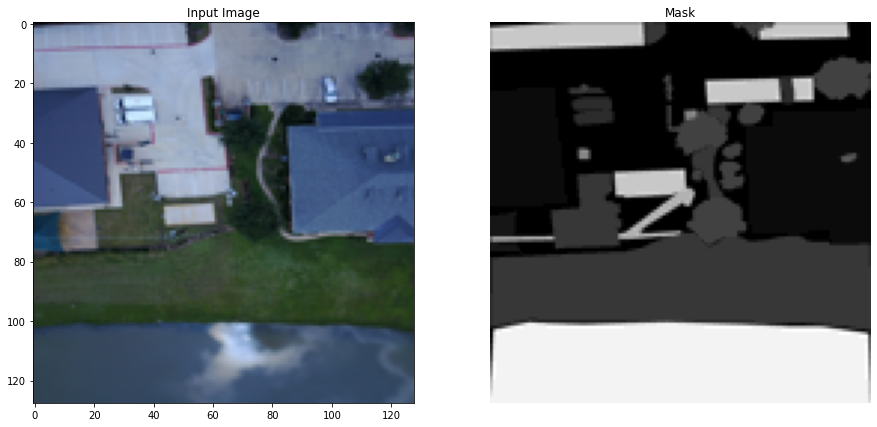

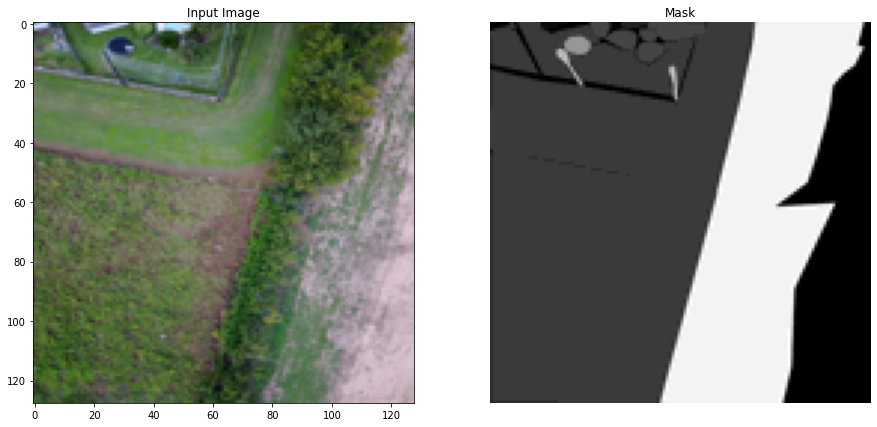

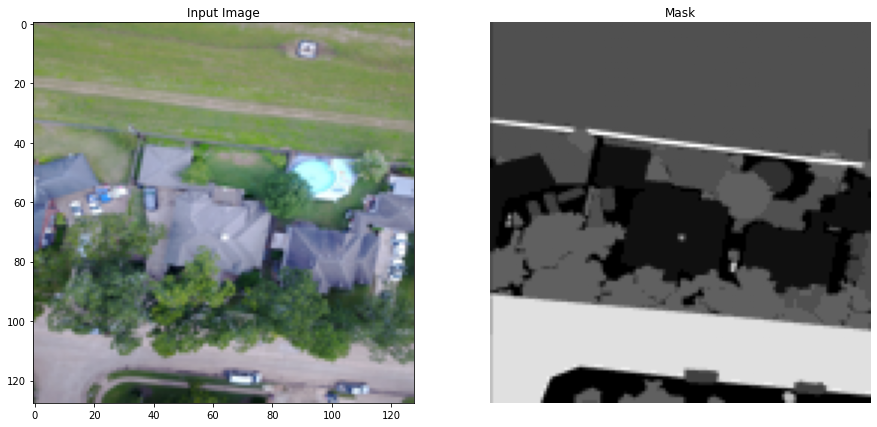

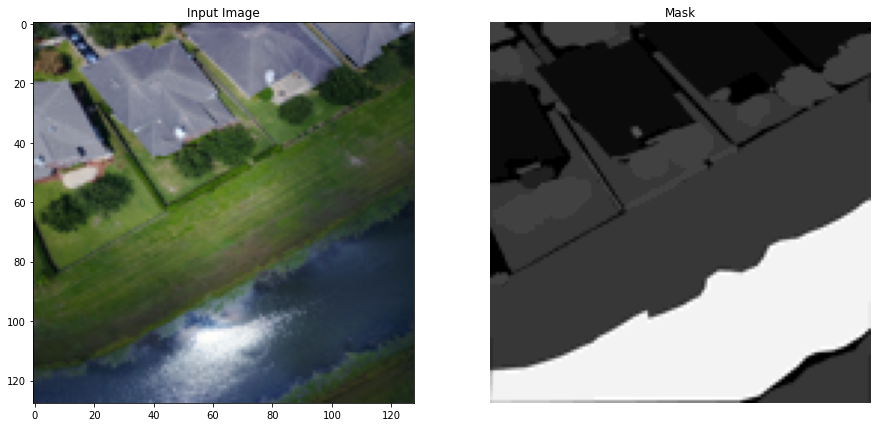

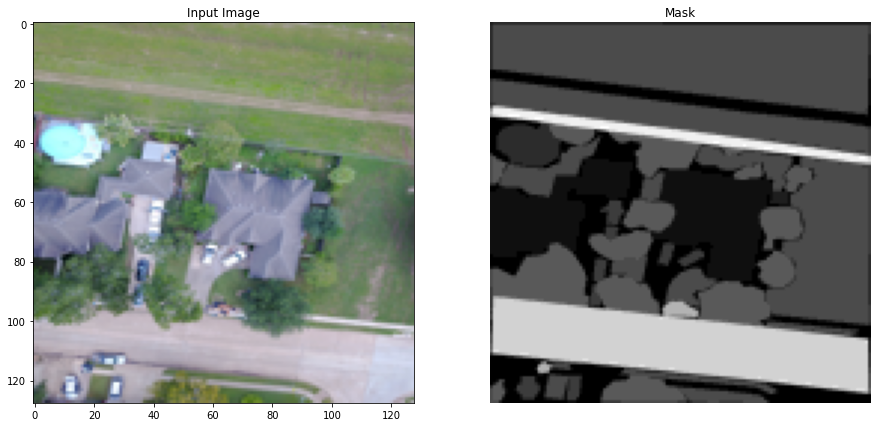

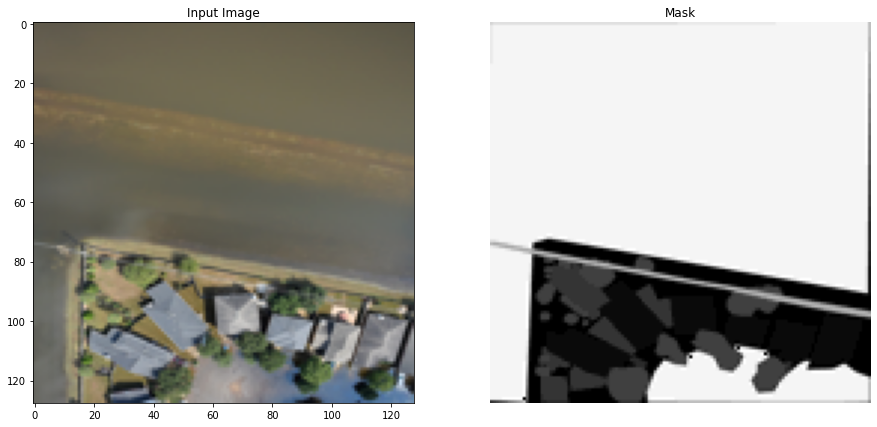

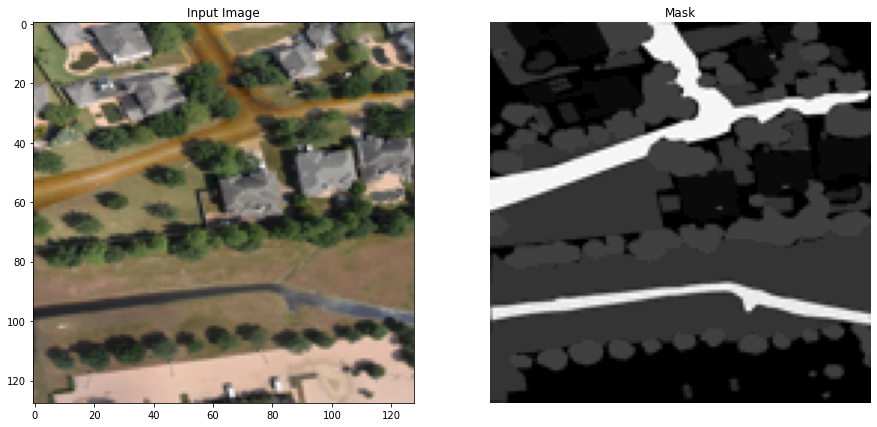

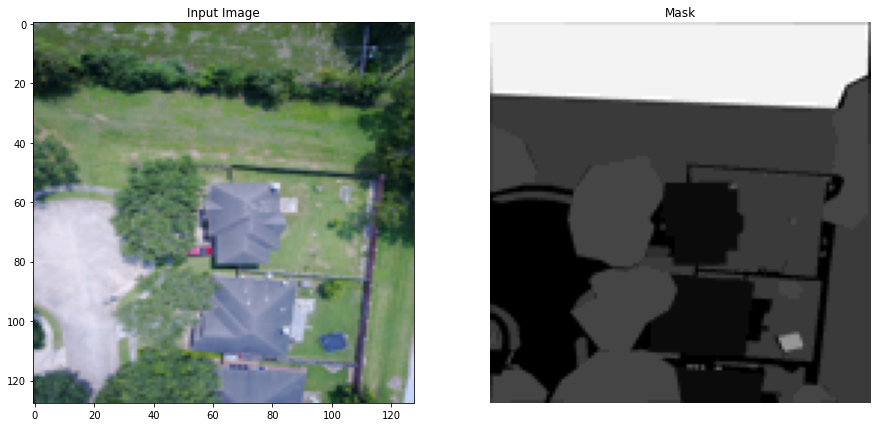

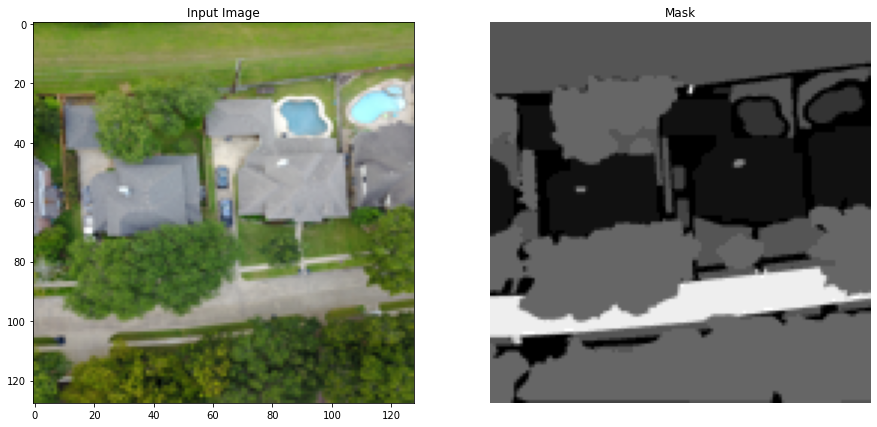

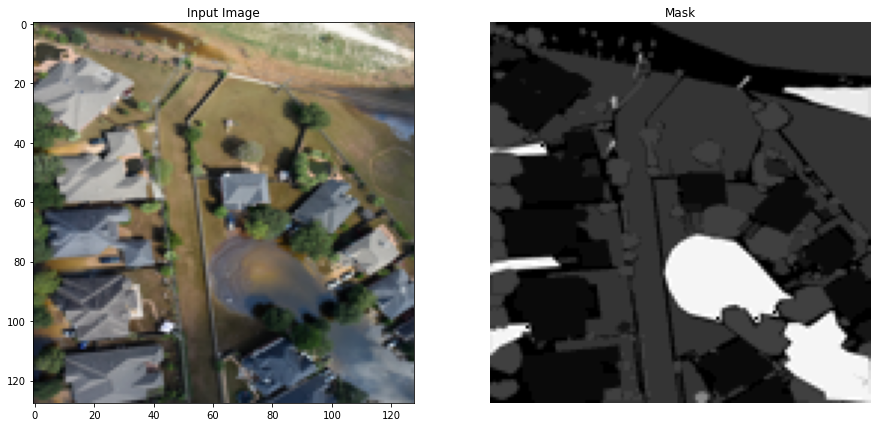

In [57]:
for i in range(10):
    current_image = train_images[i]
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(array_to_img(current_image))

    current_mask = train_masks[i]
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(current_mask, cmap="gray")
    plt.axis('off')
    plt.show()

In [58]:
print(np.unique(train_masks))
print("number of classes is", len(np.unique(train_masks)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
number of classes is 25


In [61]:
model = unet_model(25)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

EPOCHS = 20
VAL_SUBSPLITS = 5
# VALIDATION_STEPS = info.splits['test'].num_examples
model_history = model.fit(train_generator, 
                          epochs=EPOCHS),
                          # steps_per_epoch=STEPS_PER_EPOCH)
                          # validation_split=0.2)
                          # validation_steps=VALIDATION_STEPS,
                          # validation_data=test_dataset,
                          # callbacks=[DisplayCallback()])

Epoch 1/20
17/17 [==============================] - 6s 134ms/step - loss: 5.1516 - accuracy: 0.1036
Epoch 2/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5941 - accuracy: 0.1355
Epoch 3/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5749 - accuracy: 0.1396
Epoch 4/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5598 - accuracy: 0.1402
Epoch 5/20
17/17 [==============================] - 2s 124ms/step - loss: 3.5538 - accuracy: 0.1399
Epoch 6/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5676 - accuracy: 0.1408
Epoch 7/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5726 - accuracy: 0.1398
Epoch 8/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5764 - accuracy: 0.1378
Epoch 9/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5822 - accuracy: 0.1377
Epoch 10/20
17/17 [==============================] - 2s 124ms/step - loss: 3.5742 - accuracy: 0.1372

In [48]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (10, 8)) 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import glob         # file operations
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image # Image I/O (e.g. Image.open)
import matplotlib.pyplot as plt

In [ ]:
# Input data files are available in the read-only "../input/" directory
train_images = '../input/fdl2022/train_images/train_images/'
train_masks = '../input/fdl2022/train_masks/train_masks/'
test_image = '../input/fdl2022/test_images/test_images/'

In [ ]:
# Get the directories of all images and masks
train_x = sorted(glob.glob(train_images+'*.jpg'))
train_y = sorted(glob.glob(train_masks+'*.png'))
test_x = glob.glob(test_image+'*.jpg')

print('Train Images:', len(train_x))
print('Test Images:', len(test_x))

In [ ]:
# Randomly select and image/mask pair from the training set
idx = np.random.choice(range(len(train_x)))
img = Image.open(train_x[idx])
msk = Image.open(train_y[idx])

print('Image Size:',img.size)
print('Mask Size:',msk.size)

# Show the image
plt.imshow(img.resize((512,512)))
plt.imshow(msk.resize((512,512)), alpha=0.5)
plt.show()

In [ ]:
builder = tfds.ImageFolder('../input/fdl2022/')
print(builder.info)  # num examples, labels... are automatically calculated
train_images = builder.as_dataset(split='train_images', shuffle_files=False)
tfds.show_examples(train_images, builder.info)

train_masks = builder.as_dataset(split='train_masks', shuffle_files=False)
tfds.show_examples(train_masks, builder.info)

test_images = builder.as_dataset(split='test_images', shuffle_files=False)
tfds.show_examples(test_images, builder.info)

In [ ]:
train_masks

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples

model_history = model.fit(train_masks, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_images,
                          callbacks=[DisplayCallback()])